# Airbnb General Linear Models Project


The aim of this notebook is to take Airbnb data and analyse the prices of the rentals using binomial and count data. The analysis has various steps:
1. Data Inspection
2. Investigating research questions, using GLMs. 

## Analysis Summary 

Using a general linear model, we tested the hypothesis that price can be explained by the combination of count and bionomial data: person capacity, overall rating, private rooms and host is superhost variables.

Our model performed better (AIC value comparison) than the null hypothesis, suggesting that this hypothesis can be accepted. However, the residuals were not normally distributed, meaning we 

# Full Code

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from patsy import dmatrices
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Importing the Data

In [6]:
# Importing the google sheet into our notebook

doc_id = "1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY"
sheet_names = ["amsterdam_weekdays", "amsterdam_weekends", "athens_weekdays", "athens_weekends", "berlin_weekends", 
               "barcelona_weekdays", "barcelona_weekends", "berlin_weekdays", "budapest_weekdays", 
               "budapest_weekends", "lisbon_weekdays", "lisbon_weekends", "london_weekdays", 
               "london_weekends", "paris_weekdays", "paris_weekends", "rome_weekdays", 
               "rome_weekends", "vienna_weekdays", "vienna_weekends"]
city_country_map = {
    "amsterdam": "Netherlands",
    "athens": "Greece",
    "berlin": "Germany",
    "barcelona": "Spain",
    "budapest": "Hungary",
    "lisbon": "Portugal",
    "london": "United Kingdom",
    "paris": "France",
    "rome": "Italy",
    "vienna": "Austria"
}
dataframes = []
for sheet_name in sheet_names:
    url = f"https://docs.google.com/spreadsheets/d/{doc_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)
    city, day_type = sheet_name.split("_")
    df['City'] = city.capitalize()  
    df['Country'] = city_country_map.get(city, "Unknown")  
    df['DayType'] = "Weekday" if day_type == "weekdays" else "Weekend"
    dataframes.append(df)

In [103]:
# Combinging the seperate sheets into one dataframe table 
combined_df = pd.concat(dataframes, ignore_index=True)
# combined_df.to_csv("asda_homework.csv", index=False)

# Renaming the realSum column to 'Price'
combined_df = combined_df.rename(columns={'realSum': 'Price'}).drop(columns=['Unnamed: 0'])

In [105]:
combined_df['no_of_listings'] = combined_df.apply(lambda row: '1' if row['multi'] == 0 and row['biz'] == 0 
    else '2-4' if row['multi'] == 1 and row['biz'] == 0 
    else '>4' if row['multi'] == 0 and row['biz'] == 1 
    else 'unknown', axis=1)
combined_df = combined_df.drop(columns=['multi', 'biz'])
column_order = list(combined_df.columns)
insert_position = column_order.index('host_is_superhost') + 1  # Position after 'host_is_superhost'
column_order.insert(insert_position, column_order.pop(column_order.index('no_of_listings'))) # The place of column will be same as multi & biz
combined_df = combined_df[column_order]
combined_df.head(3)

,Price,room_type,room_shared,room_private,person_capacity,host_is_superhost,no_of_listings,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,City,Country,DayType
0,194.033698,Private room,False,True,2,False,2-4,10,93,1,...,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,Netherlands,Weekday
1,344.245776,Private room,False,True,4,False,1,8,85,1,...,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,Netherlands,Weekday
2,264.101422,Private room,False,True,2,False,>4,9,87,1,...,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,Netherlands,Weekday


## Part 1: Inspecting the Data

In [89]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Price                       51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  bool   
 3   room_private                51707 non-null  bool   
 4   person_capacity             51707 non-null  int64  
 5   host_is_superhost           51707 non-null  bool   
 6   no_of_listings              51707 non-null  object 
 7   cleanliness_rating          51707 non-null  int64  
 8   guest_satisfaction_overall  51707 non-null  int64  
 9   bedrooms                    51707 non-null  int64  
 10  dist                        51707 non-null  float64
 11  metro_dist                  51707 non-null  float64
 12  attr_index                  51707 non-null  float64
 13  attr_index_norm             517

We want to make a model using bionomial and count data. Therefore, attributes we may be interested are:
1. Room type
2. Room shared
3. Room private
4. Person capacity
5. Host is superhost
6. Cleanliness rating
7. Guest statisfaction overall
8. Bedrooms

Because we are using GLM, it does not matter if our data is normally distributed or not. However, we will quicly inspect the count and binomial distributions to see how they are distributed. 

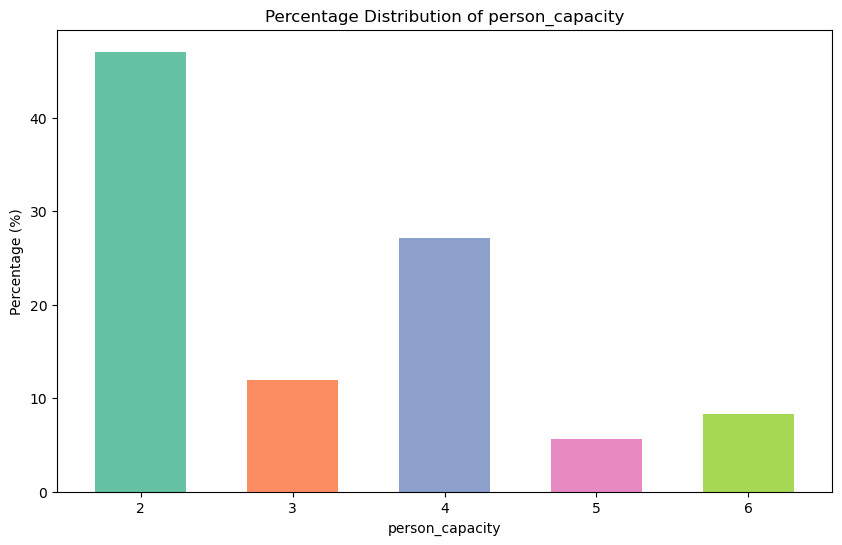

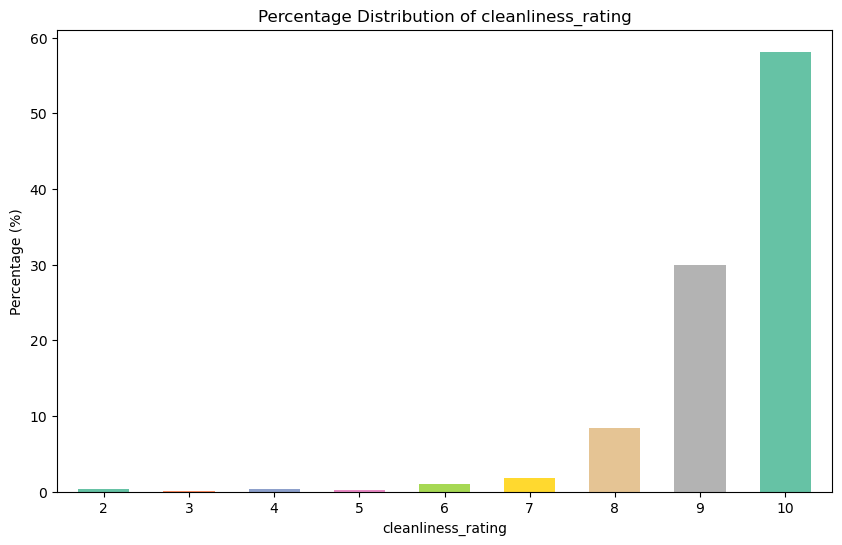

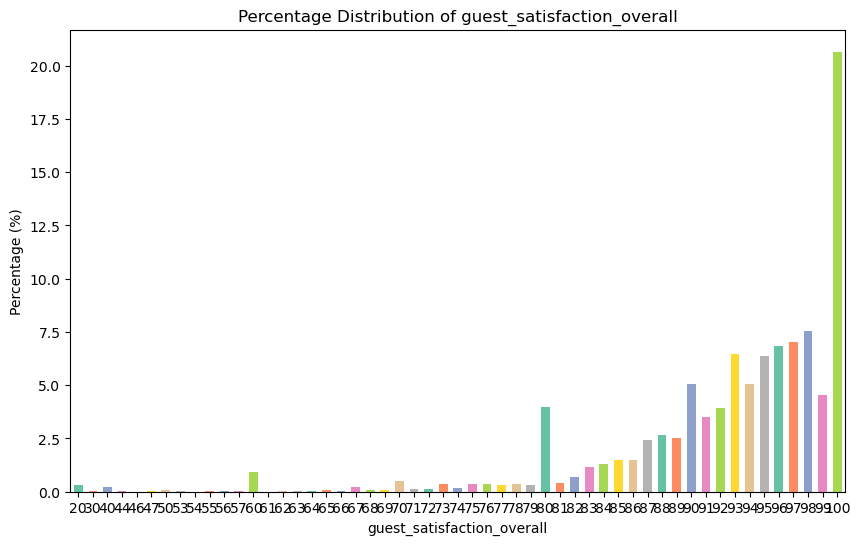

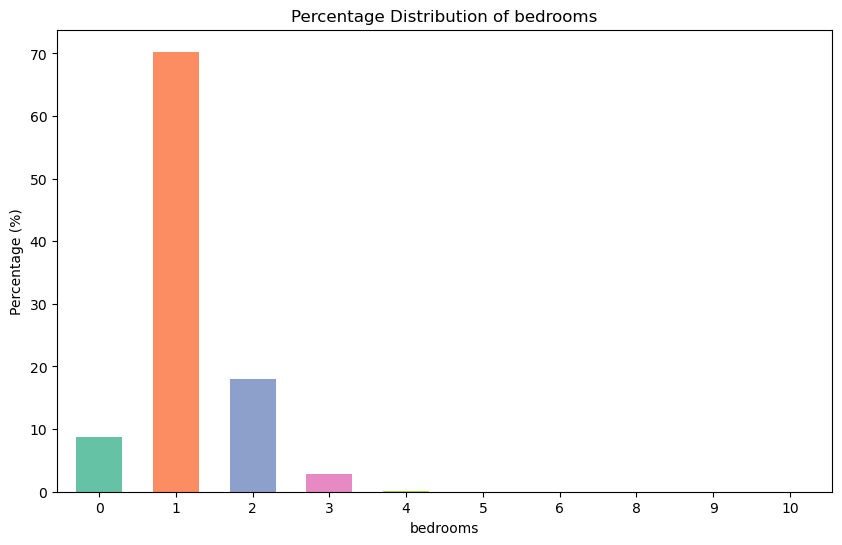

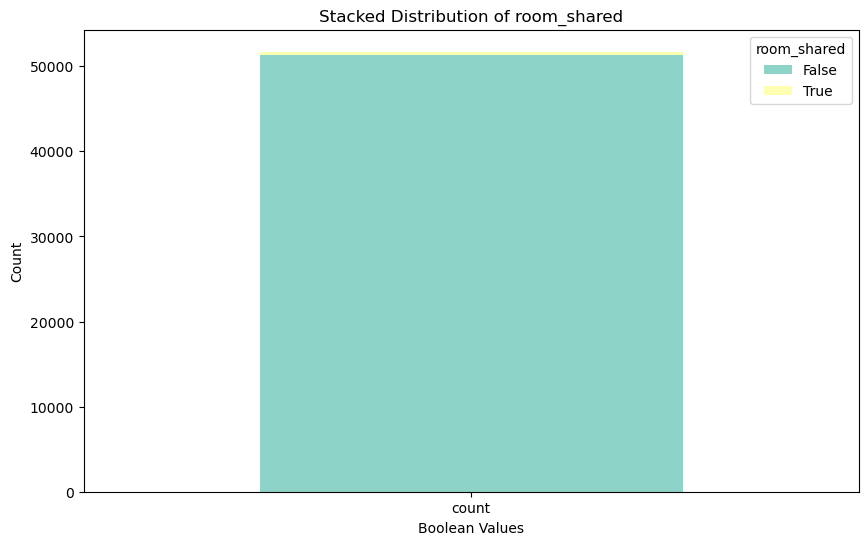

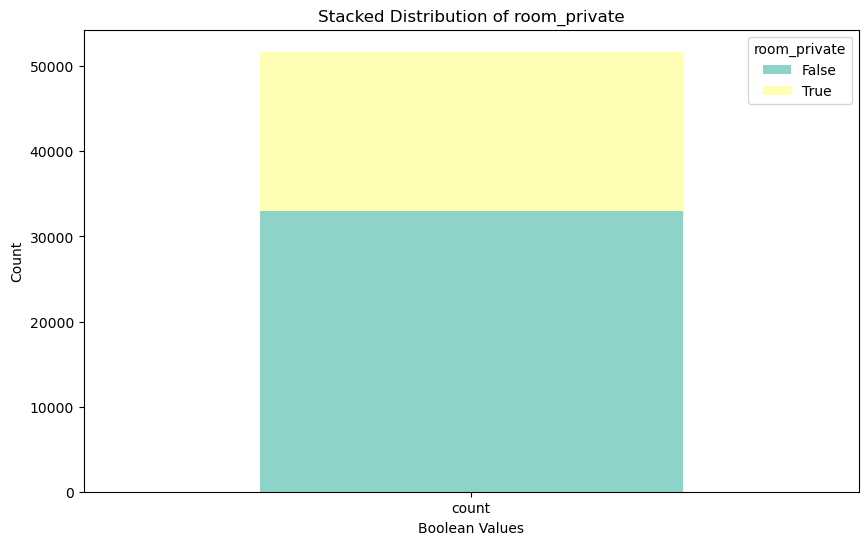

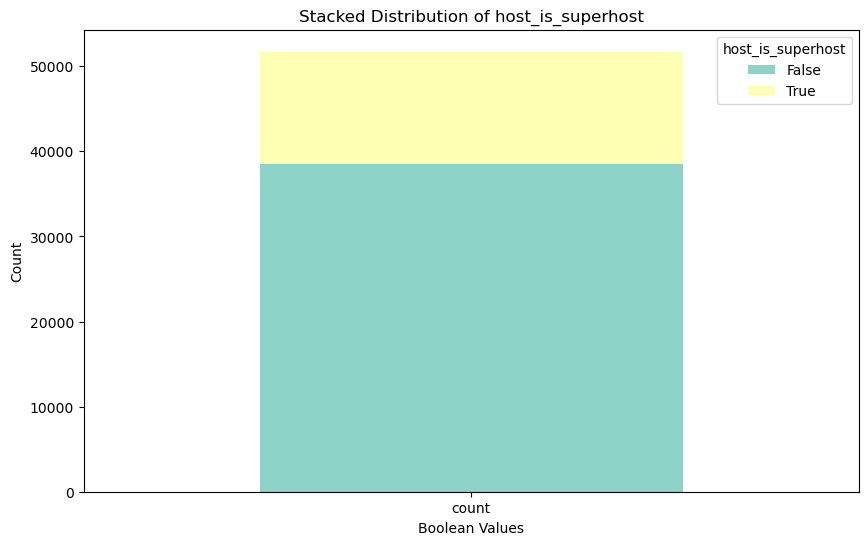

In [111]:

# Step 1: Plotting Stacked Percentage Bar Plots for Integer Columns
def plot_integer_stacked_percent(df, columns):
    for col in columns:
        # Calculate value counts for each integer column and convert to percentage
        value_counts = df[col].value_counts(normalize=True) * 100
        value_counts = value_counts.sort_index()  # Sort the index (values) for consistent plot
        
        # Plotting
        value_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=sns.color_palette("Set2", len(value_counts)), width=0.6)
        plt.title(f"Percentage Distribution of {col}")
        plt.ylabel('Percentage (%)')
        plt.xlabel(col)
        plt.xticks(rotation=0)
        plt.show()

# List of integer columns
int_columns = ['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms']

# Plot for integer columns
plot_integer_stacked_percent(combined_df, int_columns)


# Step 2: Plotting Stacked Bar Plots for Boolean Columns
def plot_boolean_stacked_by_row(df, columns):
    for col in columns:
        # Count the number of True/False for each row in the boolean columns
        stacked_data = df[col].value_counts().to_frame().T  # True/False counts per column
        
        # Plotting
        stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=sns.color_palette("Set3", 2), width=0.6)
        plt.title(f"Stacked Distribution of {col}")
        plt.ylabel('Count')
        plt.xlabel('Boolean Values')
        plt.xticks(rotation=0)
        plt.legend(title=col, labels=['False', 'True'])
        plt.show()

# List of boolean columns
bool_columns = ['room_shared', 'room_private', 'host_is_superhost']

# Plot for boolean columns
plot_boolean_stacked_by_row(combined_df, bool_columns)

For the GLMS, we assume that the explanatory variables are independent from one another. Therefore, we will test for correlation. As our variables are not normally distributed, we will use Spearmann's R. We have over 5000 datapoints so this is acceptable.

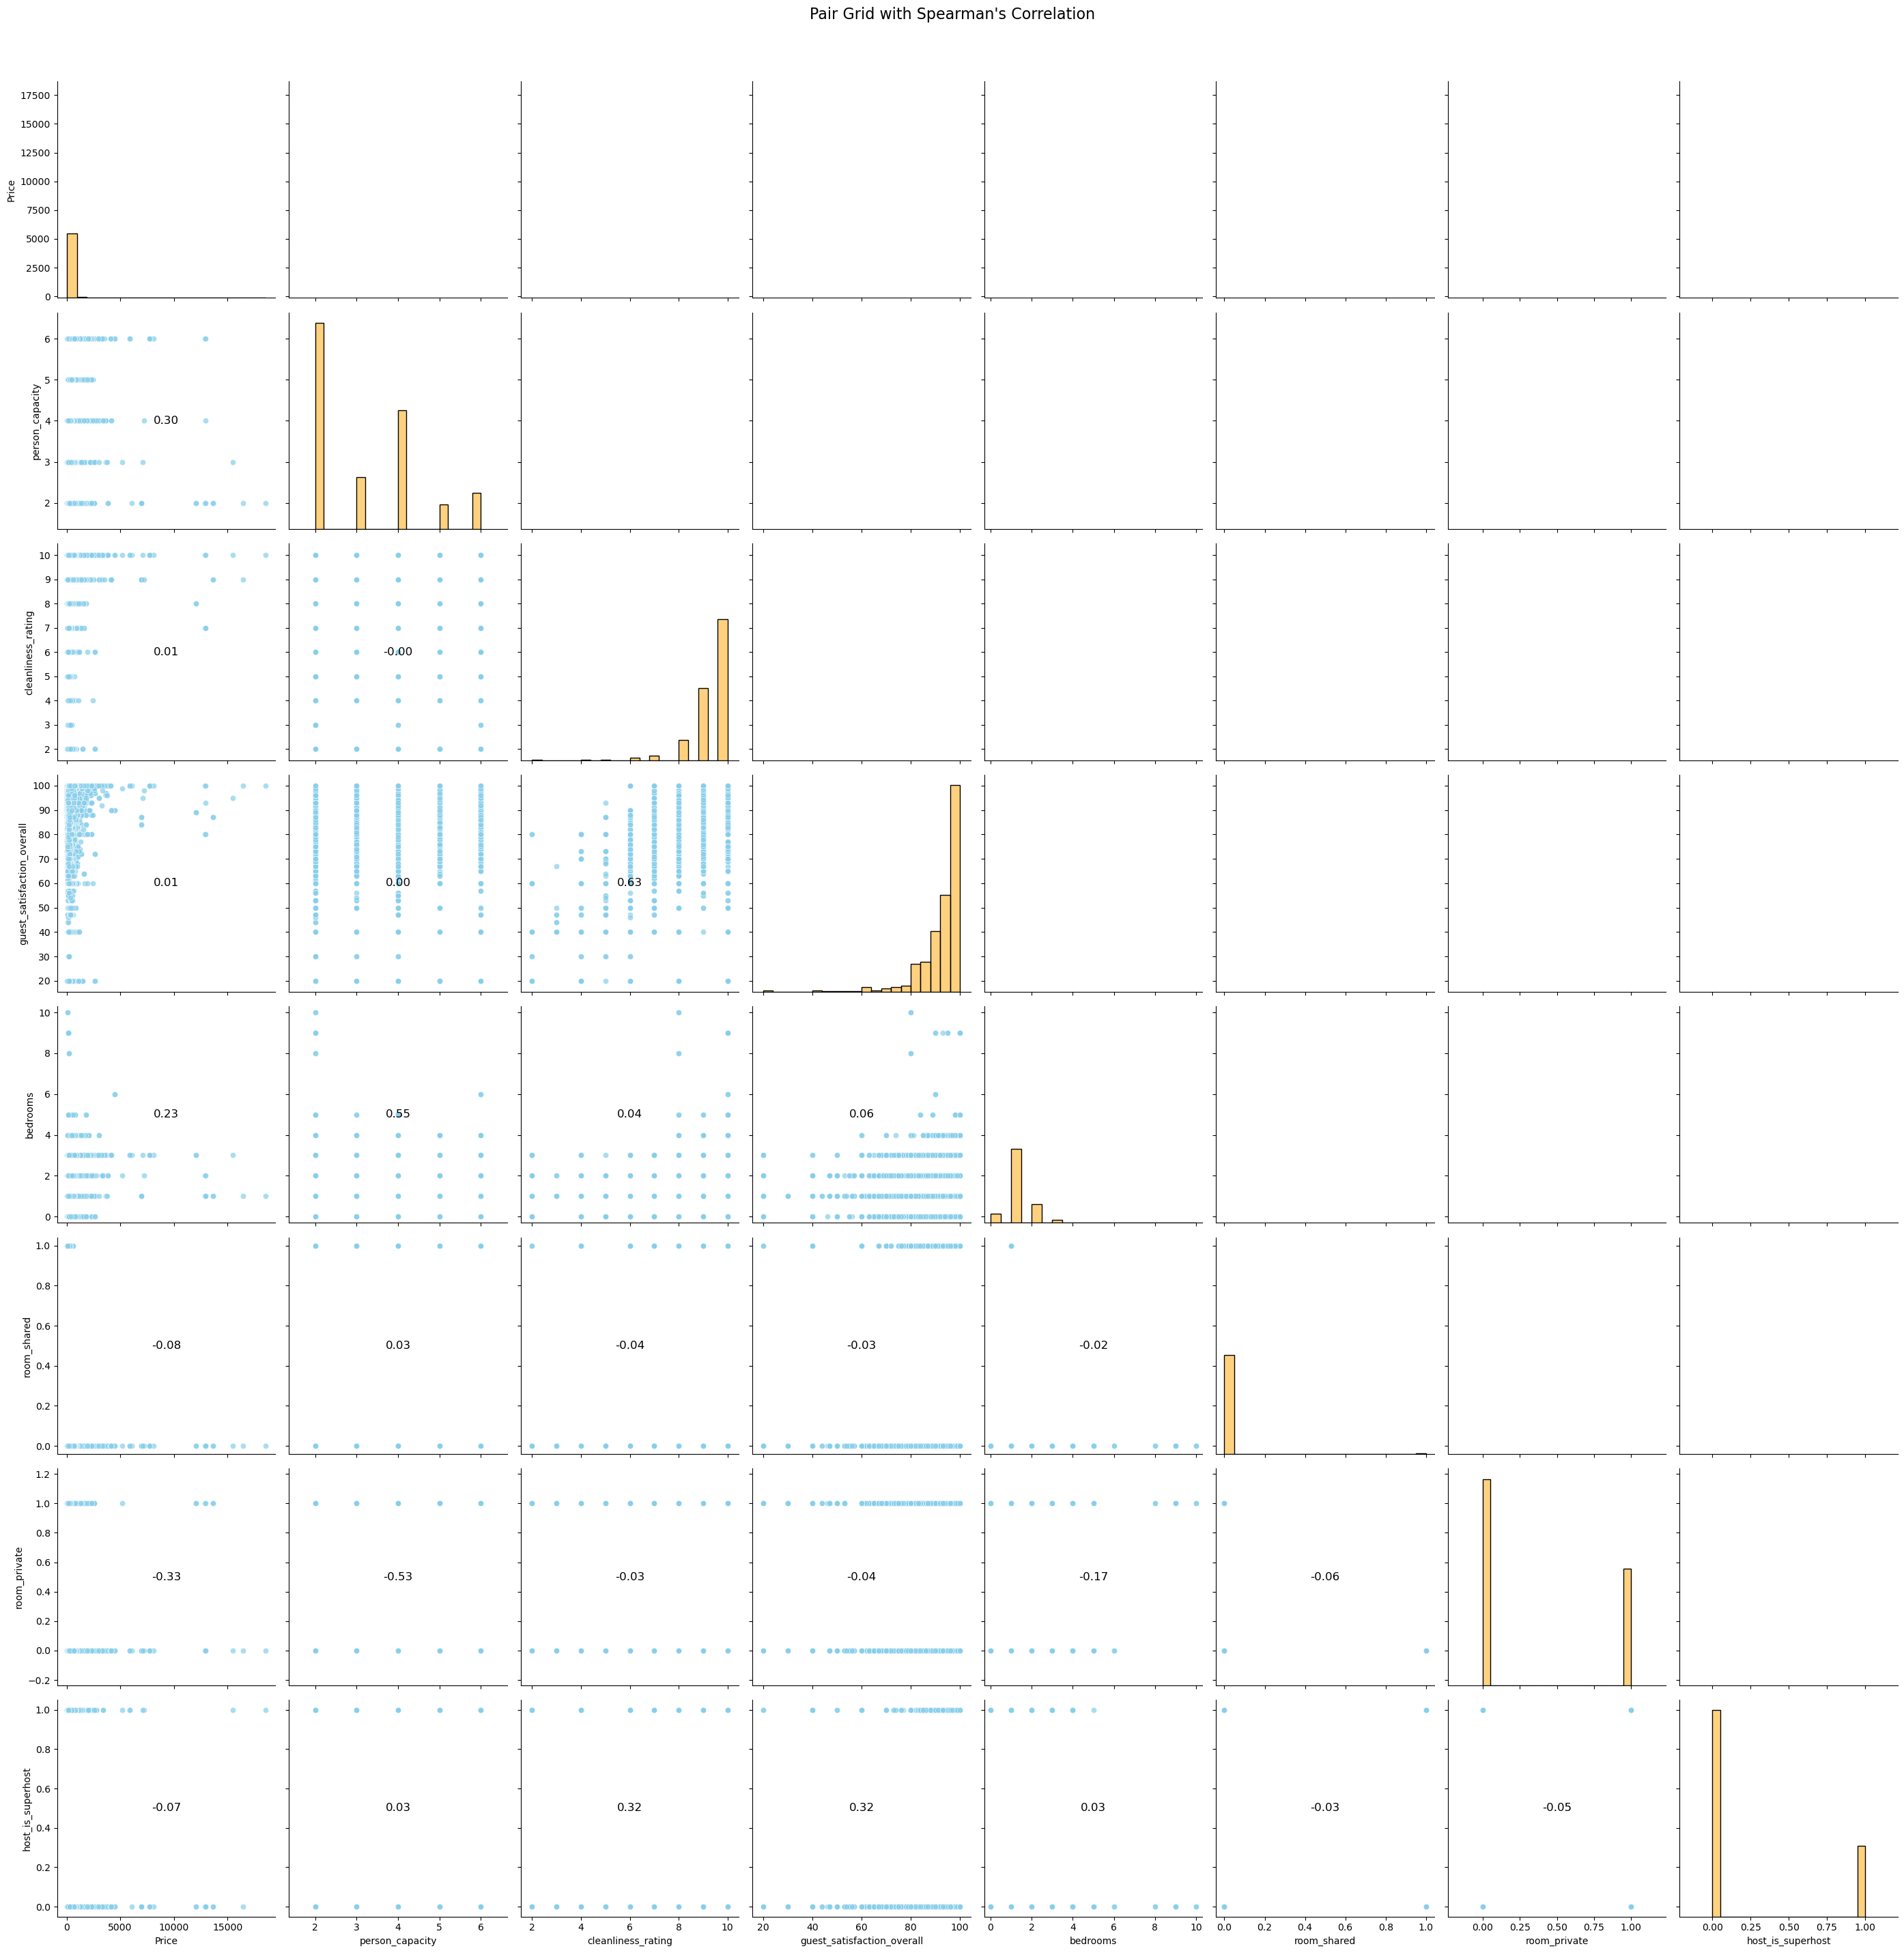

In [68]:
selected_columns = ['Price', 'person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'room_shared', 'room_private', 'host_is_superhost']

# Calculate Spearman's correlation matrix
spearman_corr = combined_df[selected_columns].corr(method='spearman')

# Create a custom function to annotate the upper triangle with Spearman's correlation
def corr_func(x, y, **kwargs):
    corr = np.corrcoef(x, y)[0, 1]
    # Return Spearman's correlation rounded to 2 decimal places
    return f"{corr:.2f}"

# Create the PairGrid object
g = sns.PairGrid(combined_df[selected_columns], height=3.5, diag_sharey=False)

# Map the scatter plots (lower triangle)
g.map_lower(sns.scatterplot, alpha=0.7, color='skyblue')

# Map the diagonal histograms
g.map_diag(sns.histplot, kde=True, color='orange', bins=20,line_kws={'linewidth': 0})

# Map the upper triangle with the correlation coefficients
g.map_upper(sns.kdeplot, cmap="Blues", alpha=0)  # Empty kdeplot for spacing

for i, j in zip(*np.tril_indices_from(spearman_corr, -1)):
    g.axes[i, j].annotate(f'{spearman_corr.iloc[i, j]:.2f}', 
                          xy=(0.5, 0.5), xycoords='axes fraction', 
                          ha='center', va='center', fontsize=12, color='black')

# Add title
g.fig.suptitle('Pair Grid with Spearman\'s Correlation', size=16, y=1.02)



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

It's also important for us to test the distribution of the variable we would like to exlain. This will decide which general model we are able to use.

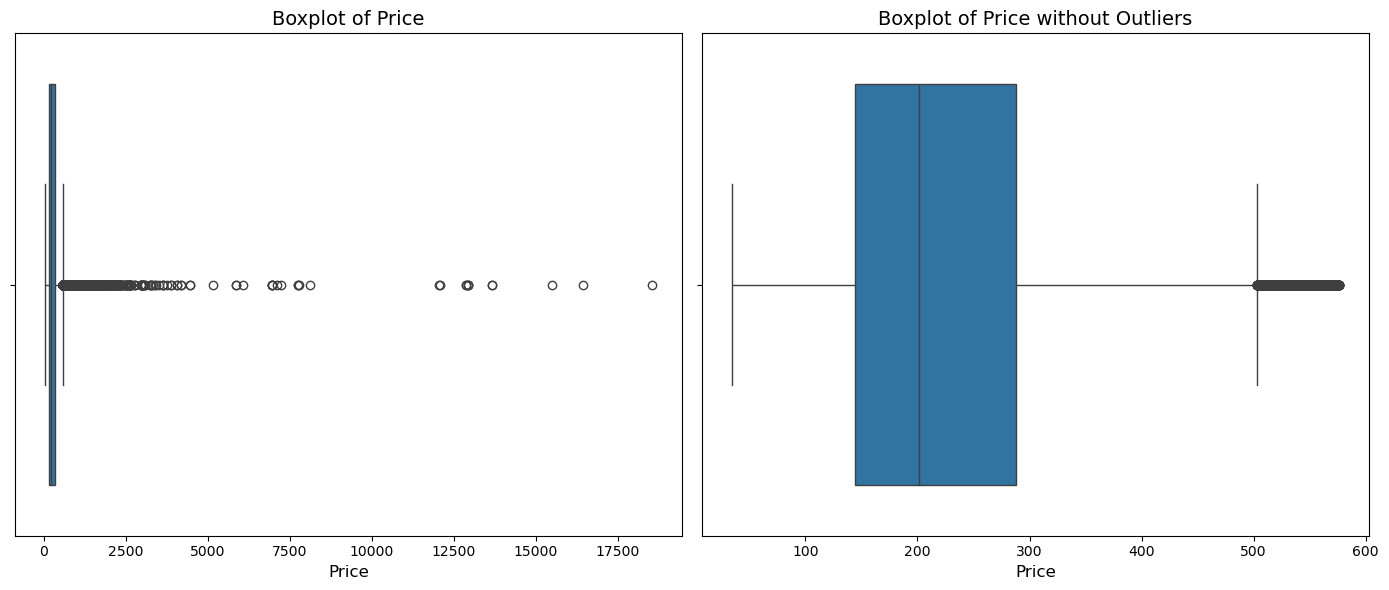

In [131]:
Q1 = combined_df['Price'].quantile(0.25)
Q3 = combined_df['Price'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers by filtering the data
df_cleaned = combined_df[(combined_df['Price'] >= lower_bound) & (combined_df['Price'] <= upper_bound)]

plt.figure(figsize=(14, 6))

# Create first boxplot for 'Price' in the first subplot (1 row, 2 columns, first plot)
plt.subplot(1, 2, 1)
sns.boxplot(x=combined_df['Price'])
plt.title('Boxplot of Price', fontsize=14)
plt.xlabel('Price', fontsize=12)

# Create second boxplot for 'Cleanliness_Rating' in the second subplot (1 row, 2 columns, second plot)
plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned['Price'])
plt.title('Boxplot of Price without Outliers', fontsize=14)
plt.xlabel('Price', fontsize=12)

# Adjust the layout to prevent overlap of plots
plt.tight_layout()

# Show the plot
plt.show()

It's clear that there are some extreme outliers outliers, we remove them from the data.

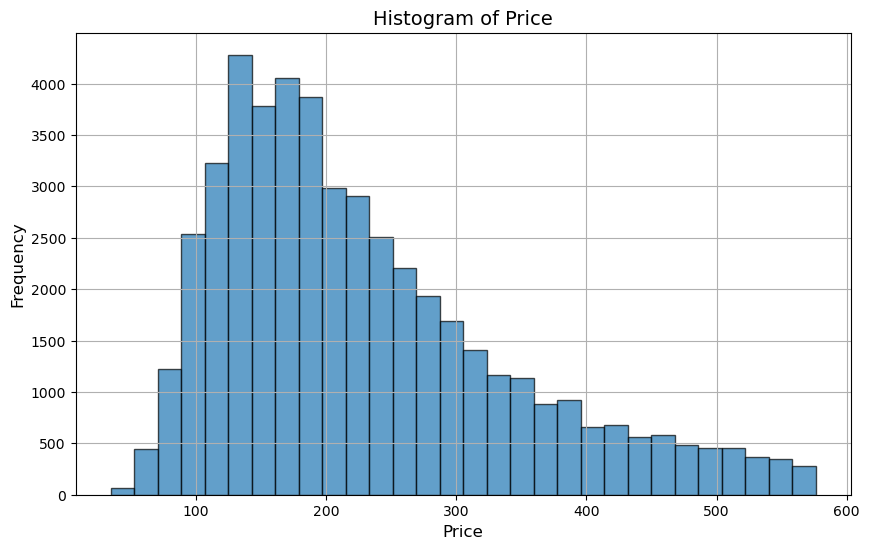

In [137]:


plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['Price'], bins=30, edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Histogram of Price', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.grid(True)
plt.show()


This shows that our price data is slightly skewed. 

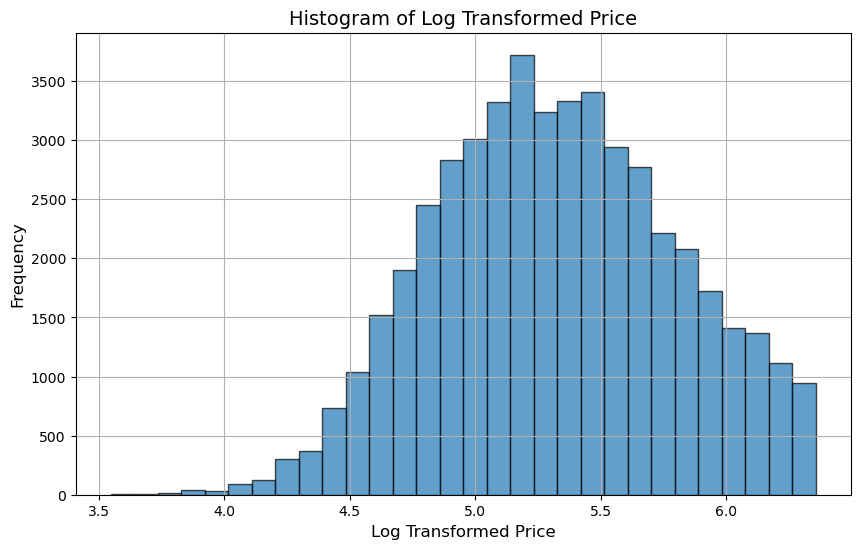

In [143]:
df_cleaned_copy = df_cleaned.copy()


df_cleaned_copy['Log_Price'] = np.log(df_cleaned_copy['Price'])


plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['Log_Price'], bins=30, edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Histogram of Log Transformed Price', fontsize=14)
plt.xlabel('Log Transformed Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.grid(True)
plt.show()

With log transformations, with our outliers the data would perhaps be more normalyl distributed /. However, for now we will use the untransformed numbers and perhaps compare later. 

# Part 2: Forming Models

Assumptions for General Linear Models:
* the design is randomised
* unique values of explanatory variables for each and every individual cases
* explanatory variable should be (ideally) continuous  (our task directly instructs us to use non-continuous data)
* no correlation between explanatory variables

Our data inspection showed that:
* guest satifaction and cleanliness are strongly correlated
* person capacity and number of rooms are correlated
* room shared and room private are correlated

Therefore we will exclude cleanliness, number of bedrooms and room private from our GLM model.

Question we would like to answer:

Can price be explained by the combination of count and bionomial data: person capacity, overall rating, private rooms and host is superhost variables?

Null hypothesis: there is no significant explanatory power for person capacity, overall rating, private rooms and host is superhost for price.


### Can price be explained by the combination of count and bionomial data: person capacity, overall rating, private rooms and host is superhost variables?

Null hypothesis: That there is no explanatory power for these characteristics.

In [191]:
# Set boolean columns to be represented as integers
df_cleaned_copy[bool_columns] = df_cleaned[bool_columns].astype(int)

y = df_cleaned_copy['Price']
null_intercepts = sm.add_constant(np.ones_like(y))

# Fit a null model (intercept-only model)
null_model = sm.OLS(y, null_intercepts).fit()
print(null_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 09 Dec 2024   Prob (F-statistic):                nan
Time:                        12:50:48   Log-Likelihood:            -2.9489e+05
No. Observations:               48045   AIC:                         5.898e+05
Df Residuals:                   48044   BIC:                         5.898e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        228.9805      0.511    447.949      0.0

In [193]:
X = df_cleaned_copy[['person_capacity', 'guest_satisfaction_overall', 'room_private', 'host_is_superhost']]
X = sm.add_constant(X)  
y = df_cleaned_copy['Price']

# Fit a linear regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     1418.
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:50:50   Log-Likelihood:            -2.9221e+05
No. Observations:               48045   AIC:                         5.844e+05
Df Residuals:                   48040   BIC:                         5.845e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Our model has a small p value suggesting it is significant; however, the overall r^2 is small. The omnibus probability suggests that our residuals are not normally distributed, perhaps we are missing other explanatory variables (likely the continuous ones). 
It seems from our condition number that our predictor variables may not be independent due to the large multicolinearity. 

Comparing the AIC values of the null and hypothesis, we can see that the full model has a lower AIC value and is therefore a more parsimonious fit for the data.

In [201]:
aic_null = null_model.aic
aic_full = model.aic

print(f"Null Model AIC: {aic_null}")
print(f"Full Model AIC: {aic_full}")

Null Model AIC: 589786.2546617874
Full Model AIC: 584433.7766687104
